# Delta-Gamma Hedging Strategy with SPY (Real Data)
In this notebook, we fetch real SPY option chain data, select call options, compute Delta and Gamma using Black-Scholes, and simulate a delta-neutral, gamma-positive hedging strategy.

## Step 1: Install & Import Libraries

In [2]:
!pip install yfinance --quiet

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

## Step 2: Fetch SPY Option Chain Data

In [4]:
spy = yf.Ticker("SPY")
spot_price = spy.history(period="1d")["Close"].iloc[-1]
expiry_dates = spy.options
nearest_expiry = expiry_dates[0]
option_chain = spy.option_chain(nearest_expiry)
calls = option_chain.calls

# Save to CSV
calls.to_csv("spy_calls_chain.csv", index=False)
print(f"SPY Spot Price: ${spot_price:.2f}")
print(f"Nearest Expiry: {nearest_expiry}")
calls[['contractSymbol', 'strike', 'lastPrice', 'impliedVolatility', 'bid', 'ask', 'volume', 'openInterest']].head()

SPY Spot Price: $632.78
Nearest Expiry: 2025-08-06


,contractSymbol,strike,lastPrice,impliedVolatility,bid,ask,volume,openInterest
0,SPY250806C00540000,540.0,81.45,1.277347,91.50,94.29,1,1
1,SPY250806C00580000,580.0,52.29,0.779299,52.85,53.00,13,22
2,SPY250806C00585000,585.0,47.97,0.753909,46.97,47.99,30,7
3,SPY250806C00590000,590.0,42.81,0.607426,42.74,43.01,14,2
4,SPY250806C00595000,595.0,37.90,0.539067,37.74,38.00,75,49


## Step 3: Select ATM and OTM Calls

In [6]:
atm_strike = min(calls['strike'], key=lambda x: abs(x - spot_price))
otm_strike = atm_strike + 10  # Choose a strike $10 higher

atm_call = calls[calls['strike'] == atm_strike].iloc[0]
otm_call = calls[calls['strike'] == otm_strike].iloc[0]

print("Selected ATM Call:", atm_call[['contractSymbol', 'strike', 'impliedVolatility']])
print("Selected OTM Call:", otm_call[['contractSymbol', 'strike', 'impliedVolatility']])

Selected ATM Call: contractSymbol       SPY250806C00633000
strike                            633.0
impliedVolatility              0.030283
Name: 38, dtype: object
Selected OTM Call: contractSymbol       SPY250806C00643000
strike                            643.0
impliedVolatility              0.125009
Name: 48, dtype: object


## Step 4: Define Black-Scholes Greeks

In [7]:
def bs_greeks(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        delta = norm.cdf(d1)
    else:
        delta = -norm.cdf(-d1)

    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return delta, gamma

## Step 5: Compute Greeks for Selected Options

In [8]:
S = spot_price
r = 0.01
T = 0.5  # Approx 6 months
sigma_atm = atm_call['impliedVolatility']
sigma_otm = otm_call['impliedVolatility']

delta_atm, gamma_atm = bs_greeks(S, atm_call['strike'], T, r, sigma_atm)
delta_otm, gamma_otm = bs_greeks(S, otm_call['strike'], T, r, sigma_otm)

net_delta = -1 * delta_atm + 2 * delta_otm
stock_units = -net_delta

print(f"ATM Delta: {delta_atm:.4f}, Gamma: {gamma_atm:.4f}")
print(f"OTM Delta: {delta_otm:.4f}, Gamma: {gamma_otm:.4f}")
print(f"Portfolio Delta: {net_delta:.4f}")
print(f"Stock units to hedge: {stock_units:.4f}")

ATM Delta: 0.5902, Gamma: 0.0287
OTM Delta: 0.4679, Gamma: 0.0071
Portfolio Delta: 0.3457
Stock units to hedge: -0.3457


## Step 6: Define Call Pricing Function

In [9]:
def call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

## Step 7: Simulate PnL Over Stock Price Range

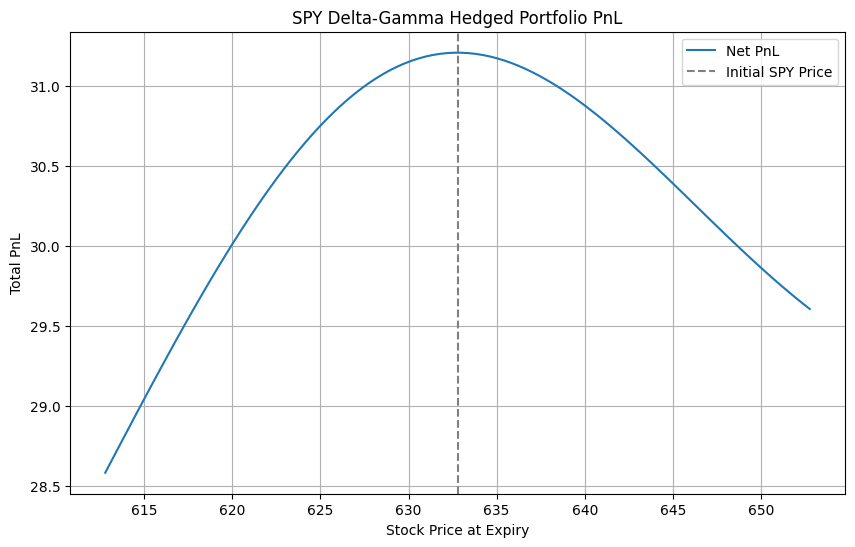

In [10]:
stock_prices = np.linspace(S - 20, S + 20, 100)
pnl = []

for s in stock_prices:
    c1 = call_price(s, atm_call['strike'], T, r, sigma_atm)
    c2 = call_price(s, otm_call['strike'], T, r, sigma_otm)
    stock_pos = stock_units * (s - S)
    net = -c1 + 2 * c2 + stock_pos
    pnl.append(net)

plt.figure(figsize=(10,6))
plt.plot(stock_prices, pnl, label='Net PnL')
plt.axvline(S, color='gray', linestyle='--', label='Initial SPY Price')
plt.title('SPY Delta-Gamma Hedged Portfolio PnL')
plt.xlabel('Stock Price at Expiry')
plt.ylabel('Total PnL')
plt.grid(True)
plt.legend()
plt.show()

## Strategy 1: Long Straddle Simulation (Theory + BS Model)

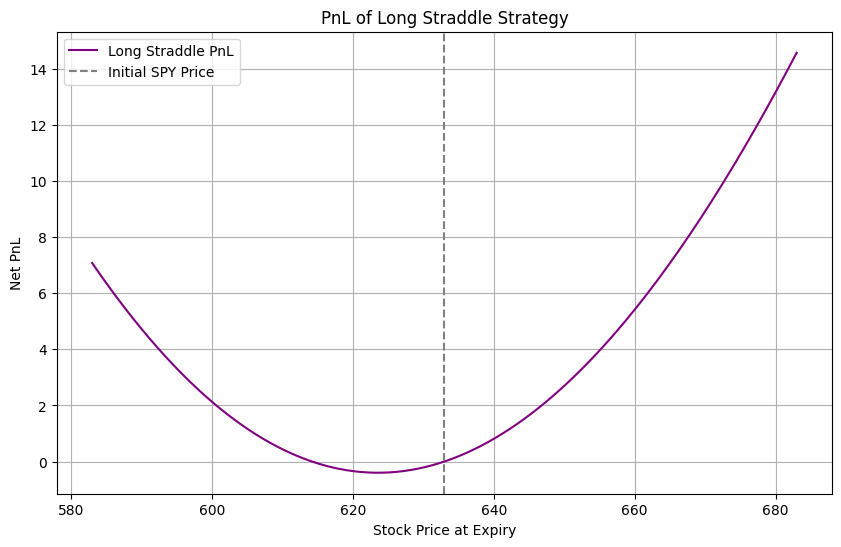

Initial SPY Price: $633
Strike Price: $633
Call Premium: 37.20, Put Premium: 34.04
Total Cost of Straddle: 71.23


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# -------------------------------
# Step 1: Define Black-Scholes Call and Put Pricing Functions
# -------------------------------

def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_put_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# -------------------------------
# Step 2: Define Parameters
# -------------------------------

S0 = 633        # Current SPY price (ATM)
K = 633         # Strike price (same for call and put)
T = 0.5         # Time to expiry (6 months)
r = 0.01        # Risk-free rate
sigma = 0.2     # Implied volatility (use real if available)

# -------------------------------
# Step 3: Simulate PnL over Price Range
# -------------------------------

stock_prices = np.linspace(S0 - 50, S0 + 50, 200)
pnl = []

# Premium paid (same time of purchase)
call_premium = bs_call_price(S0, K, T, r, sigma)
put_premium = bs_put_price(S0, K, T, r, sigma)
total_cost = call_premium + put_premium

for S in stock_prices:
    call_val = bs_call_price(S, K, T, r, sigma)
    put_val = bs_put_price(S, K, T, r, sigma)
    net = call_val + put_val - total_cost
    pnl.append(net)

# -------------------------------
# Step 4: Plot the PnL Curve
# -------------------------------

plt.figure(figsize=(10,6))
plt.plot(stock_prices, pnl, label='Long Straddle PnL', color='purple')
plt.axvline(S0, color='gray', linestyle='--', label='Initial SPY Price')
plt.title('PnL of Long Straddle Strategy')
plt.xlabel('Stock Price at Expiry')
plt.ylabel('Net PnL')
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------
# Step 5: Print Summary
# -------------------------------
print(f"Initial SPY Price: ${S0}")
print(f"Strike Price: ${K}")
print(f"Call Premium: {call_premium:.2f}, Put Premium: {put_premium:.2f}")
print(f"Total Cost of Straddle: {total_cost:.2f}")


## Strategy 2: Real Data Comparison – Straddle vs Gamma Hedging

/var/folders/w5/6skb1rd1347d48vsmg2c2f6m0000gn/T/ipykernel_58275/227654203.py:85: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/hedging/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


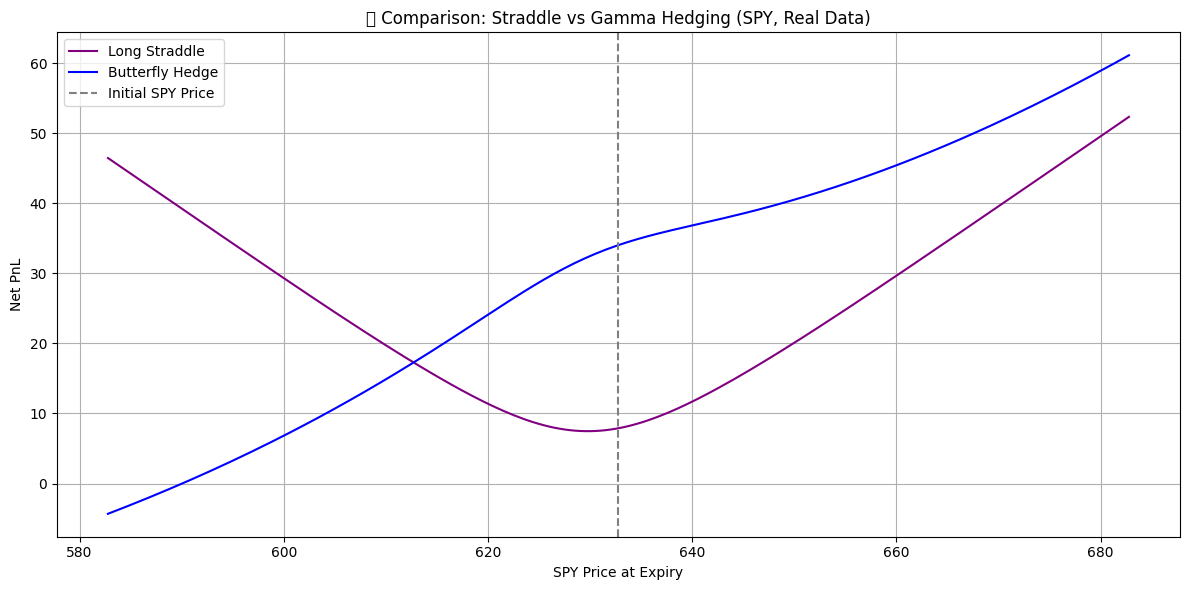

In [ ]:
# Make sure you have yfinance
# pip install yfinance

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Step 1: Load SPY & Option Chain ---
spy = yf.Ticker("SPY")
spot_price = spy.history(period="1d")["Close"].iloc[-1]
expiry_dates = spy.options
nearest_expiry = expiry_dates[0]
option_chain = spy.option_chain(nearest_expiry)
calls = option_chain.calls
puts = option_chain.puts

# --- Step 2: Pick ATM strike & fetch premiums/IV ---
atm_strike = min(calls['strike'], key=lambda x: abs(x - spot_price))
call_row = calls[calls['strike'] == atm_strike].iloc[0]
put_row = puts[puts['strike'] == atm_strike].iloc[0]

S0 = spot_price
K = atm_strike
T = 0.5
r = 0.01
sigma_call = call_row['impliedVolatility']
sigma_put = put_row['impliedVolatility']
call_price = (call_row['bid'] + call_row['ask']) / 2
put_price = (put_row['bid'] + put_row['ask']) / 2
total_straddle_cost = call_price + put_price

# --- Step 3: Option Pricing Functions ---
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def bs_put_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def bs_delta(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) if option_type == 'call' else -norm.cdf(-d1)

# --- Step 4: Simulate PnL ---
stock_prices = np.linspace(S0 - 50, S0 + 50, 200)
straddle_pnl = []
butterfly_pnl = []

# For butterfly
otm_strike = atm_strike + 10
otm_call_row = calls[calls['strike'] == otm_strike].iloc[0]
sigma_otm = otm_call_row['impliedVolatility']
delta_atm = bs_delta(S0, atm_strike, T, r, sigma_call)
delta_otm = bs_delta(S0, otm_strike, T, r, sigma_otm)
stock_units = -delta_atm + 2 * delta_otm

for S in stock_prices:
    # Straddle
    call_val = bs_call_price(S, K, T, r, sigma_call)
    put_val = bs_put_price(S, K, T, r, sigma_put)
    strad_net = call_val + put_val - total_straddle_cost
    straddle_pnl.append(strad_net)

    # Butterfly
    atm_val = bs_call_price(S, atm_strike, T, r, sigma_call)
    otm_val = bs_call_price(S, otm_strike, T, r, sigma_otm)
    stock_val = stock_units * (S - S0)
    butterfly_net = -atm_val + 2 * otm_val + stock_val
    butterfly_pnl.append(butterfly_net)

# --- Step 5: Plot ---
plt.figure(figsize=(12,6))
plt.plot(stock_prices, straddle_pnl, label="Long Straddle", color="purple")
plt.plot(stock_prices, butterfly_pnl, label="Butterfly Hedge", color="blue")
plt.axvline(S0, linestyle='--', color='gray', label="Initial SPY Price")
plt.title("Comparison: Straddle vs Gamma Hedging (SPY, Real Data)")
plt.xlabel("SPY Price at Expiry")
plt.ylabel("Net PnL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Thus, This project mirrors real-world quant research and trading logic for volatility and risk exposure.